In [0]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# import os
# print(os.listdir("./dataset"))

In [0]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/train.csv')

df_predict = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset/predict.csv')

In [0]:
def print_info(df):
    print("Shape of Dataset {}".format(df.shape))
    print("Type of Target Variable: {}".format(df.Response.dtype))
    print("Unique values in Target Variable: {}".format(df.Response.unique()))
    print("We have {} classes in Target Variable".format(len(df.Response.unique())))
    print("We have {} features in dataset".format(df.shape[1]-1))
    print("Features have {} types of value: {}".format(len(df.dtypes.unique()), df.dtypes.unique()))
    sns.countplot(x=df.Response).set_title('Distribution of rows by response categories')

def dataset_type_info(df):
    columns_df=pd.DataFrame({'column_names':df.columns,'datatypes':df.dtypes},index=None)
    x=columns_df.groupby(by=['datatypes']).count()
    x.reset_index(inplace=True)
    x.rename(columns={"column_names":"Number_of_columns"},inplace=True)
    lst=[]
    for data_type in x.datatypes:
        v=list(df.select_dtypes(include=data_type).columns)
        lst.append(v)
        x['Column_Names']=pd.Series(lst)
    return x

Shape of Dataset (58881, 129)
Type of Target Variable: int64
Unique values in Target Variable: [7 6 1 4 2 8 5 3]
We have 8 classes in Target Variable
We have 128 features in dataset
Features have 3 types of value: [dtype('int64') dtype('O') dtype('float64')]


,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,InsuredInfo_8,InsuredInfo_9,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,1,A8,26,0.230769,2,3,1,0.492537,0.563636,0.225941,0.510720,0.0244,9,1,0.0,2,0.05,2,2,3,3,1,1,Female,NaN,Muslim,2,1,1,3,NaN,3,2,3,3,0.681159,NaN,0.492958,NaN,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7
1,1,D2,26,1.000000,3,3,1,0.671642,0.781818,0.326360,0.453033,0.5000,3,1,0.5,2,1.00,1,2,8,3,1,1,Male,NaN,NaN,2,1,3,1,0.006667,1,3,2,2,NaN,0.490196,NaN,0.589286,4.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
2,1,D2,26,0.230769,2,3,1,0.626866,0.745455,0.393305,0.598310,0.0400,9,1,0.0,2,0.60,1,2,4,3,1,1,Male,Caucasian,Jewish,1,3,3,1,0.000833,1,1,2,3,NaN,0.558824,NaN,0.598214,3.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,1,D4,26,0.230769,2,3,1,0.268657,0.690909,0.246862,0.410638,0.0300,9,1,0.0,2,0.00,1,2,6,2,1,1,Female,NaN,NaN,2,1,1,3,NaN,3,2,3,2,0.536232,NaN,0.478873,NaN,12.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
4,1,E1,10,0.230769,2,3,1,0.641791,0.581818,0.466527,1.000000,0.0280,9,1,0.0,3,1.00,1,2,8,3,1,1,Female,NaN,NaN,2,1,3,1,0.000039,1,3,2,2,NaN,0.647059,NaN,0.160714,1.0,...,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,2


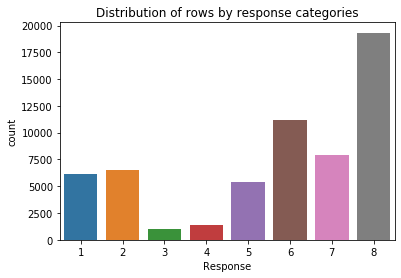

In [134]:
print_info(df_train)
df_train.head(5)

### Observations from Target variable
    1. Majority of data is for Response 8, followed by 6,7, 2
    2. Lowest data is for Response 3, followed by 4
    3. Response = 1,2,5 show almost same distribution of data
    4. Target variable is "Response" and it has 8 classes, out of 8 data seems to be skewed towards class 8

## Date preprocessing

### 1. Missing value info

In [0]:
def missing_value_info(df):
    total_num = df.shape[0]
    null_counts = df.notnull().sum()[df.notnull().sum() != total_num].sort_values(ascending=False)
    cols_with_null = (total_num - null_counts) / total_num * 100
    return cols_with_null

In [135]:
cols_with_null = missing_value_info(df_train)
print("Columns with null values(>30%) shown in percentage(%)")
print(cols_with_null[cols_with_null > 30])

Columns with null values(>30%) shown in percentage(%)
Family_Hist_4          32.317726
Insurance_History_5    42.764219
Family_Hist_2          48.270240
Family_Hist_3          57.662064
Family_Hist_5          70.399620
InsuredInfo_9          74.940983
Medical_History_15     75.097230
InsuredInfo_8          87.919702
Medical_History_24     93.593859
Medical_History_32     98.131825
Medical_History_10     99.064214
dtype: float64


In [0]:
# Register the columns' names with more than 50% data missing
cols_2_delete = missing_value_info(df_train)[missing_value_info(df_train) > 50].index.to_list()
df_train = df_train.drop(cols_2_delete, axis=1)
cols_2_delete = []

### Perform label encoding and imputation

#### Observations from missing map and missing percentage:
    1. Majority of columns dont have missing values
    2. Target variable doesn't have any missing values
    3. Few columns have few missing values, whereas few columns have too much missing values

In [11]:
df_train['Product_Info_2'].head(5)

0    A8
1    D2
2    D2
3    D4
4    E1
Name: Product_Info_2, dtype: object

In [12]:
df_train['InsuredInfo_7'].head(5)

0    Female
1      Male
2      Male
3    Female
4    Female
Name: InsuredInfo_7, dtype: object

#### As the Column InsuredInfo_7 refers to the gender information, so we should elimite it (avoid sex discrimination)

In [137]:
df_train = df_train.drop("InsuredInfo_7", axis=1)
dataset_type_info(df_train)

,datatypes,Number_of_columns,Column_Names
0,int64,107,"[Product_Info_1, Product_Info_3, Product_Info_..."
1,float64,12,"[Product_Info_4, Ins_Age, Ht, Wt, BMI, Employm..."
2,object,1,[Product_Info_2]


#### Seems like we still have one column in string format, so we need to encode it.

In [0]:
le = LabelEncoder()
df_train['Product_Info_2_en'] = le.fit_transform(df_train['Product_Info_2'])
df_train.drop(axis=1, labels=['Product_Info_2'], inplace=True)

In [0]:
cols_with_null = missing_value_info(df_train)

In [0]:
# Filling columns with missing units with its column's mean value
for index in cols_with_null.index:
    mean = df_train[index].mean()
    df_train[index] = df_train[index].fillna(mean)

In [141]:
missing_value_info(df_train)

Series([], dtype: float64)

### Dataset -> StandardScaler

In [0]:
std_scaler = StandardScaler()
# features = df_train.drop('Response', axis=1)
# features_scaled = std_scaler.fit_transform(features.values)
# df_train[features.columns] = features_scaled

In [0]:
df_train_scaled = df_train.drop('Response', axis=1)
features_scaled = std_scaler.fit_transform(df_train_scaled.values)
df_train_scaled[df_train_scaled.columns] = features_scaled

In [0]:
corr_low = df_train.corr()['Response'][df_train.corr()['Response'].abs()<0.01].abs()
df_train = df_train.drop(corr_low.index, axis=1)

In [20]:
df_train.shape

(58881, 101)

In [21]:
df_train

,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_6,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,Insurance_History_2,Insurance_History_5,Family_Hist_1,Family_Hist_2,Family_Hist_4,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_16,Medical_History_17,...,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_7,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_40,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Product_Info_2_en
0,-0.164753,0.312443,-0.347216,0.441665,0.440658,-1.934894,-0.748760,0.337777,-0.645395,0.084692,-0.420863,-0.203243,-0.408317,-9.850954e-01,1.892875,-0.08667,-1.060172,0.363259,-0.117511,-0.140322,-0.169146,-8.095580e-15,0.649408,1.851882e+00,3.576905e-01,-0.662156,-0.795028,-0.337092,0.726027,-0.085875,0.241527,-0.071024,-0.151201,0.546231,0.064809,-0.245031,0.361924,0.159083,-0.442976,0.149842,...,-0.227562,-0.121171,-0.093195,-0.118546,-0.081656,-0.194486,-0.247668,-0.100434,-0.077218,-0.088929,-0.484980,-0.11351,-0.08677,-0.096835,-0.121818,-0.196733,-0.329385,-0.139059,-0.313497,-0.116766,-0.109291,-0.123317,-0.108812,-0.160405,-0.105076,-0.152894,-0.145276,-0.083635,-0.102653,-0.266991,-0.083119,-0.245809,-0.218286,-0.103746,-0.087067,-0.092451,-0.142695,-0.240244,7,-1.016653
1,-0.164753,0.312443,2.375290,0.441665,1.348853,1.003749,0.379437,-0.134423,5.121987,-1.334818,-0.420863,15.935319,-0.408317,2.021001e+00,-0.500442,-0.08667,0.809515,0.363259,-0.117511,-0.140322,-0.169146,8.855935e-01,-1.419625,-2.041129e-14,2.656529e-13,-0.329841,-0.520715,-0.337092,-1.377359,-0.085875,0.241527,-0.071024,-0.151201,-1.829323,0.064809,4.078520,0.361924,0.159083,-0.442976,0.149842,...,-0.227562,-0.121171,-0.093195,-0.118546,-0.081656,-0.194486,-0.247668,-0.100434,-0.077218,-0.088929,-0.484980,-0.11351,-0.08677,-0.096835,-0.121818,-0.196733,-0.329385,-0.139059,-0.313497,-0.116766,-0.109291,-0.123317,-0.108812,-0.160405,-0.105076,-0.152894,-0.145276,-0.083635,-0.102653,-0.266991,-0.083119,-0.245809,-0.218286,-0.103746,-0.087067,-0.092451,-0.142695,-0.240244,6,0.460781
2,-0.164753,0.312443,-0.347216,0.441665,1.121804,0.513975,1.131568,1.054750,-0.456221,0.084692,-0.420863,-0.203243,-0.408317,7.552762e-01,-0.500442,-0.08667,-0.686235,0.363259,-0.117511,-0.140322,5.912982,-1.614414e-01,0.649408,-2.041129e-14,2.656529e-13,-0.412920,-1.405235,-0.337092,-1.377359,-0.085875,0.241527,-0.071024,-0.151201,0.546231,0.064809,-0.245031,0.361924,0.159083,-0.442976,0.149842,...,-0.227562,-0.121171,-0.093195,-0.118546,-0.081656,-0.194486,-0.247668,-0.100434,-0.077218,-0.088929,-0.484980,-0.11351,-0.08677,-0.096835,-0.121818,-0.196733,3.035964,-0.139059,3.189825,-0.116766,-0.109291,-0.123317,-0.108812,-0.160405,-0.105076,-0.152894,-0.145276,11.956727,-0.102653,3.745441,-0.083119,-0.245809,-0.218286,-0.103746,-0.087067,-0.092451,-0.142695,-0.240244,1,0.460781
3,-0.164753,0.312443,-0.347216,0.441665,-0.694586,-0.220686,-0.513719,-0.481446,-0.577486,0.084692,-0.420863,-0.203243,-0.408317,-1.143311e+00,-0.500442,-0.08667,0.061640,-2.752859,-0.117511,-0.140322,-0.169146,-8.095580e-15,-1.419625,5.521397e-01,

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import classification_report,recall_score,accuracy_score,precision_score
from sklearn.model_selection import train_test_split

In [151]:
y = df_train.Response
X = df_train.drop(labels=['Response'],axis=1)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=.30,random_state=0)
X_train_scaled, X_valid_scaled, y_train, y_valid = train_test_split(df_train_scaled, y, random_state=0, test_size=.30)

# print shape of dataset
print("Shape of X_train dataset {}".format(X_train.shape))
print("Shape of X_test dataset {}".format(X_valid.shape))

print("Shape of y_train dataset {}".format(y_train.shape))
print("Shape of y_valid dataset {}".format(y_valid.shape))

Shape of X_train dataset (41216, 119)
Shape of X_test dataset (17665, 119)
Shape of y_train dataset (41216,)
Shape of y_valid dataset (17665,)


In [0]:
#set seed for same results everytime
seed=0

#declare the models
dt=DecisionTreeClassifier(random_state=seed)
rf=RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=seed)
lr=LogisticRegression(random_state=seed)
adb=ensemble.AdaBoostClassifier(random_state=seed, n_estimators=200, learning_rate=0.1)
gbc=ensemble.GradientBoostingClassifier(n_estimators=500,random_state=seed, learning_rate=0.1)
xgb=XGBClassifier(n_estimators=900, learning_rate=0.1, random_state=seed)
svc=SVC(kernel='linear', C=1, gamma=0.1, random_state=seed)


#create a list of models
models=[dt,rf,lr,adb,gbc,xgb]
#models = [rf]

def score_model(X_train,y_train,X_valid,y_valid):
    df_columns=[]
    df=pd.DataFrame(columns=df_columns)
    i=0
    #read model one by one
    for model in models:
        model.fit(X_train,y_train)
        y_pred=model.predict(X_valid)
        
        #compute metrics
        train_accuracy=model.score(X_train,y_train)
        test_accuracy=model.score(X_valid,y_valid)
        
        p_score=metrics.precision_score(y_valid,y_pred, average='weighted')
        r_score=metrics.recall_score(y_valid,y_pred, average='weighted')
        f1_score=metrics.f1_score(y_valid,y_pred, average='weighted')
        
        
        #insert in dataframe
        df.loc[i,"Model_Name"]=model.__class__.__name__
        df.loc[i,"Precision"]=round(p_score,2)
        df.loc[i,"Recall"]=round(r_score,2)
        df.loc[i,"Train_Accuracy"]=round(train_accuracy,2)
        df.loc[i,"Test_Accuracy"]=round(test_accuracy,2)
        df.loc[i,"F1_Score"]=round(f1_score,2)
        
        
        i+=1
    
    #sort values by accuracy
    df.sort_values(by=['F1_Score'],ascending=False,inplace=True)
    return(df)

In [181]:
report=score_model(X_train, y_train, X_valid, y_valid)
report


,Model_Name,Precision,Recall,Train_Accuracy,Test_Accuracy,F1_Score
4,GradientBoostingClassifier,0.52,0.54,0.64,0.54,0.52
5,XGBClassifier,0.52,0.55,0.62,0.55,0.52
1,RandomForestClassifier,0.48,0.51,0.57,0.51,0.45
3,AdaBoostClassifier,0.43,0.48,0.48,0.48,0.43
0,DecisionTreeClassifier,0.40,0.40,1.00,0.40,0.40
2,LogisticRegression,0.20,0.36,0.36,0.36,0.23


In [34]:
report=score_model(X_train_scaled,y_train,X_valid_scaled,y_valid)
report

,Model_Name,Precision,Recall,Train_Accuracy,Test_Accuracy,F1_Score
4,GradientBoostingClassifier,0.52,0.54,0.63,0.54,0.52
5,XGBClassifier,0.52,0.54,0.62,0.54,0.52
1,RandomForestClassifier,0.48,0.51,0.57,0.51,0.46
2,LogisticRegression,0.45,0.48,0.49,0.48,0.45
3,AdaBoostClassifier,0.43,0.48,0.48,0.48,0.43
0,DecisionTreeClassifier,0.40,0.39,1.00,0.39,0.39


### Plotting feature importance

Text(0.5, 1.0, 'Feature Importance by RandomForest Application')

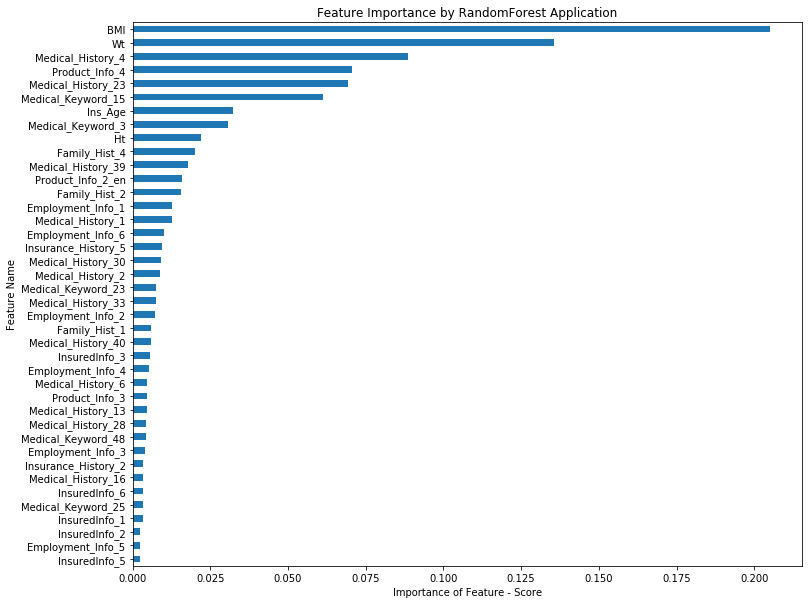

In [39]:
importances_rf = pd.Series(models[1].feature_importances_, index=X.columns).sort_values()[-40:]
importances_rf.plot(kind='barh', figsize=(12,10))
plt.xlabel('Importance of Feature - Score')
plt.ylabel('Feature Name')
plt.title("Feature Importance by RandomForest Application")

Text(0.5, 1.0, 'Feature Importance by Xgboost Application')

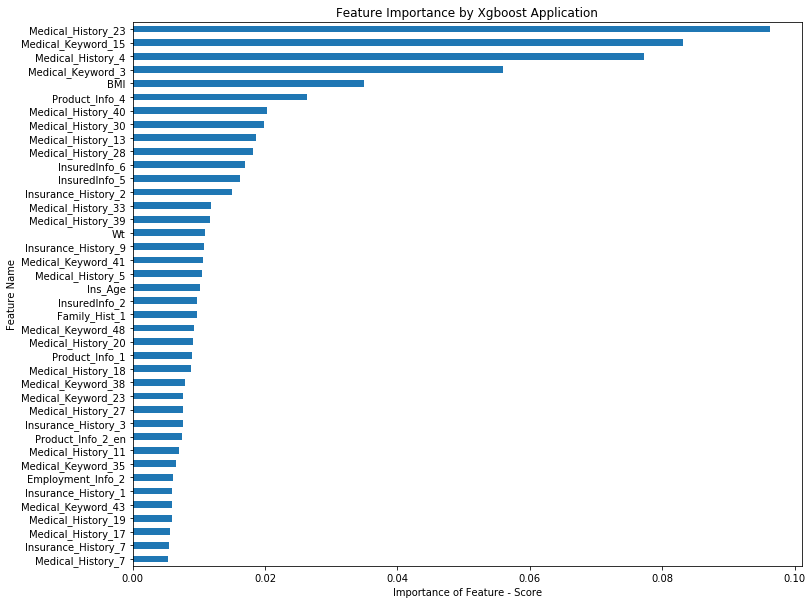

In [183]:
importances_xgb = pd.Series(models[-1].feature_importances_, index=X.columns).sort_values()[-40:]
importances_xgb.plot(kind='barh', figsize=(12,10))
plt.xlabel('Importance of Feature - Score')
plt.ylabel('Feature Name')
plt.title("Feature Importance by Xgboost Application")

Text(0.5, 1.0, 'Feature Importance by GradientDescentBoosting Application')

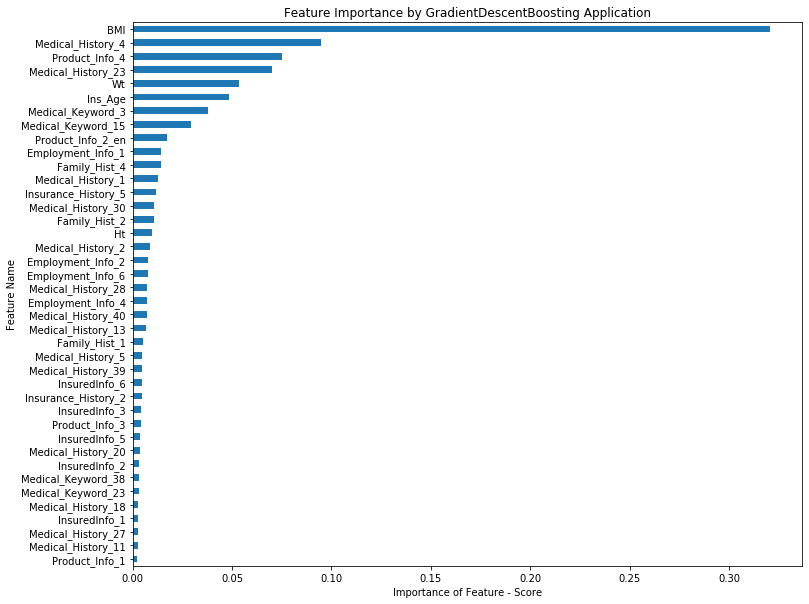

In [41]:
importances_gbc = pd.Series(models[-2].feature_importances_, index=X.columns).sort_values()[-40:]
importances_gbc.plot(kind='barh', figsize=(12,10))
plt.xlabel('Importance of Feature - Score')
plt.ylabel('Feature Name')
plt.title("Feature Importance by GradientDescentBoosting Application")

In [0]:
importance_list = [importances_gbc, importances_rf, importances_xgb]

In [0]:
list_HI_featuresName = importances_gbc.index.intersection(importances_rf.index).intersection(importances_xgb.index)
list_HI_featuresName_Union = importances_gbc.index.union(importances_rf.index).union(importances_xgb.index)

In [68]:
list_HI_featuresName

Index(['InsuredInfo_1', 'Medical_Keyword_23', 'InsuredInfo_2', 'InsuredInfo_5',
       'Product_Info_3', 'Insurance_History_2', 'InsuredInfo_6',
       'Medical_History_39', 'Family_Hist_1', 'Medical_History_13',
       'Medical_History_40', 'Medical_History_28', 'Employment_Info_2',
       'Medical_History_30', 'Medical_History_1', 'Family_Hist_4',
       'Product_Info_2_en', 'Medical_Keyword_15', 'Medical_Keyword_3',
       'Ins_Age', 'Wt', 'Medical_History_23', 'Product_Info_4',
       'Medical_History_4', 'BMI'],
      dtype='object')

In [74]:
list_HI_featuresName_Union

Index(['BMI', 'Employment_Info_1', 'Employment_Info_2', 'Employment_Info_3',
       'Employment_Info_4', 'Employment_Info_5', 'Employment_Info_6',
       'Family_Hist_1', 'Family_Hist_2', 'Family_Hist_4', 'Ht', 'Ins_Age',
       'Insurance_History_2', 'Insurance_History_5', 'InsuredInfo_1',
       'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_5', 'InsuredInfo_6',
       'Medical_History_1', 'Medical_History_11', 'Medical_History_13',
       'Medical_History_16', 'Medical_History_17', 'Medical_History_18',
       'Medical_History_19', 'Medical_History_2', 'Medical_History_20',
       'Medical_History_23', 'Medical_History_27', 'Medical_History_28',
       'Medical_History_30', 'Medical_History_31', 'Medical_History_33',
       'Medical_History_39', 'Medical_History_4', 'Medical_History_40',
       'Medical_History_5', 'Medical_History_6', 'Medical_History_7',
       'Medical_Keyword_15', 'Medical_Keyword_23', 'Medical_Keyword_25',
       'Medical_Keyword_3', 'Medical_Keyword_35', 'Medi

### Next, we try to train our model by using the most important features.

In [0]:
# Intersections
X_train_focusOnImportantF = X_train[list_HI_featuresName]
X_valid_focusOnImportantF = X_valid[list_HI_featuresName]

# Union
X_train_focusOnImportantF_Union = X_train[list_HI_featuresName_Union]
X_valid_focusOnImportantF_Union = X_valid[list_HI_featuresName_Union]

In [65]:
report_focusOnImportantF = score_model(X_train_focusOnImportantF, y_train, X_valid_focusOnImportantF, y_valid)
report_focusOnImportantF

,Model_Name,Precision,Recall,Train_Accuracy,Test_Accuracy,F1_Score
4,GradientBoostingClassifier,0.51,0.53,0.60,0.53,0.51
5,XGBClassifier,0.51,0.54,0.59,0.54,0.51
1,RandomForestClassifier,0.49,0.52,0.58,0.52,0.48
2,LogisticRegression,0.43,0.47,0.47,0.47,0.43
3,AdaBoostClassifier,0.43,0.48,0.48,0.48,0.43
0,DecisionTreeClassifier,0.39,0.39,1.00,0.39,0.39


In [79]:
report_focusOnImportantF = score_model(X_train_focusOnImportantF_Union, y_train, X_valid_focusOnImportantF_Union, y_valid)
report_focusOnImportantF

,Model_Name,Precision,Recall,Train_Accuracy,Test_Accuracy,F1_Score
4,GradientBoostingClassifier,0.52,0.54,0.63,0.54,0.52
5,XGBClassifier,0.52,0.54,0.61,0.54,0.52
1,RandomForestClassifier,0.49,0.52,0.58,0.52,0.47
2,LogisticRegression,0.44,0.48,0.48,0.48,0.44
3,AdaBoostClassifier,0.43,0.48,0.48,0.48,0.43
0,DecisionTreeClassifier,0.40,0.39,1.00,0.39,0.40


In [187]:
# So we will choose Xgboost to be our predict model
from sklearn.externals import joblib
joblib.dump(xgb, "trained_XgbModel.m")

['trained_XgbModel.m']